In [368]:
import abc
import copy
import random
from collections import defaultdict
import os
import time

import numpy as np
import joblib

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

### Common classes
Selector and replacer do no depend on encoding

In [586]:
class Problem(abc.ABC):
    pass


class Selector(abc.ABC):
    @abc.abstractmethod
    def __call__(self, n, fitnesses):
        pass

    
class TournamentSelector(Selector):
    def __init__(self, tournament_size=4):
        self.tournament_size = tournament_size
        
    def __call__(self, n, fitnesses):
        indexed_fitnesses = [(i, f) for i, f in enumerate(fitnesses)]      
        selected = []
        
        for _ in range(n):
            competitors = random.sample(indexed_fitnesses, self.tournament_size)
            
            f_max = None
            i_max = None
            for i, f in competitors:
                if not f_max or f > f_max:
                    i_max = i
                    f_max = f
            
            selected.append(i_max)
            
        return selected
        
        
class RouletteSelector(Selector):
    def __call__(self, n, fitnesses):
        # fitnesses must be non-negative for this selector
        r = np.max(fitnesses) - np.min(fitnesses)
        if r > 1.e-5:
            fitnesses_scaled = fitnesses - np.min(fitnesses) + 0.1 * r
        else:
            fitnesses_scaled = fitnesses - np.min(fitnesses) + 1.
        fitnesses_scaled = fitnesses_scaled / sum(fitnesses_scaled)
        fitnesses_cumsum = np.cumsum(fitnesses_scaled)
        
        selected = []
        for _ in range(n):
            wheel = np.random.random()
            for i, fc in enumerate(fitnesses_cumsum):
                if wheel < fc:
                    selected.append(i)
                    break
        
        return selected
    
    
class RankSelector(RouletteSelector):
    def __call__(self, n, fitnesses):
        ranks = np.argsort(fitnesses) + 1
        return super(RankSelector, self).__call__(n, ranks)
    

class Mutator(abc.ABC):
    def __init__(self, p, problem):
        self.p = p   # mutation probability
        self.problem = problem
        
    @abc.abstractmethod
    def __call__(individual):
        pass

    
class Recombiner(abc.ABC):
    def __init__(self, p, problem):
        self.p = p
        self.problem = problem
        
    @abc.abstractmethod
    def __call__(individual_A, individual_B):
        pass
    

class Replacer(abc.ABC):
    @abc.abstractmethod
    def __call__(self, parents, parent_fitnesses, children, children_fitnesses):
        pass    
    
    
class DeleteAllReplacer(Replacer):
    def __call__(self, parents, parent_fitnesses, children, children_fitnesses):
        return children, children_fitnesses

    
class TestReplacer(Replacer):
    def __call__(self, parents, parent_fitnesses, children, children_fitnesses):
        return parents, parent_fitnesses

    
class ElitesReplacer(Replacer):
    """Replace n weakest children with n strongest parents,
       thus ensuring that fitness never drops. Can be interpreted as a variant of steady-state replacer
    """
    def __init__(self, n=3):
        self.n = n
        
        self.prev_max = -1.e10
 
    def __call__(self, parents, parent_fitnesses, children, children_fitnesses):
        p_argsort = np.argsort(parent_fitnesses)
        elites_indexes = p_argsort[-self.n:]

        c_argsort = np.argsort(children_fitnesses)
        weakling_indexes = c_argsort[:self.n]   

        next_generation = copy.copy(children)
        next_generation_fitnesses = children_fitnesses.copy()

        for i in range(self.n):
            c = weakling_indexes[i]
            p = elites_indexes[i]
            next_generation[c] = parents[p]
            next_generation_fitnesses[c] = parent_fitnesses[p]
    
        return next_generation, next_generation_fitnesses
 
    

class GeneticAlgorithm:
    def __init__(self, problem, population_size, selector, mutator, recombiner, replacer, verbose=True):
        self.verbose=verbose
        
        self.problem = problem
        self.selector = selector
        self.mutator = mutator
        self.recombiner = recombiner
        self.replacer = replacer
        self.population_size = population_size
                         
        self.population = [self.problem.random_individual() 
                           for _ in range(population_size)]
        self.fitnesses = np.array([self.problem.fitness(i) for i in self.population])
        
        self.prev_max_fitness = 0
        self.max_fitness = max(self.fitnesses)
        self.max_fitnesses = [self.max_fitness]
                    
    def run(self, n_steps):
        # seed random number generators in multiprocessing environment
        seed = int(str(hash(time.time() + os.getpid()))[:-10])
        np.random.seed(seed)
        random.seed(seed)
        
        for it in range(n_steps):
            # print only when current best solution improves
            if self.verbose:
                if self.max_fitness != self.prev_max_fitness:
                    print(f'iteration {it}, max_fitness: {self.max_fitness}')

            selected = self.selector(self.population_size, self.fitnesses)
            parents = [self.population[i].copy() for i in selected]
            parent_fitnesses = np.array([self.fitnesses[i] for i in selected])          
            
#             ids = [id(p) for p in parents]
#             if len(set(ids)) < len(ids):
#                 print('there are equal ids still')
#             print(f'it: {it}, ids: {ids}')
            
            children = []
            for p1, p2 in zip(parents[0::2], parents[1::2]):
                c1, c2 = self.recombiner(p1, p2)
                c1 = self.mutator(c1)
                c2 = self.mutator(c2)
                children.extend([c1, c2])
            
            children_fitnesses = np.array([self.problem.fitness(i) for i in children])
            self.population, self.fitnesses = self.replacer(self.population, self.fitnesses, 
                                                            children, children_fitnesses)
            
            self.prev_max_fitness = self.max_fitness
            self.max_fitness = max(self.fitnesses)
            self.max_fitnesses.append(self.max_fitness)
        
        i_best = np.argmax(self.fitnesses)
        best_individual = self.population[i_best]
#         print(i_best, self.fitnesses[i_best], self.fitnesses)
        history = np.array(self.max_fitnesses)
        
        return best_individual, problem.decode_individual(best_individual), history

### Binary coding specific classes

In [279]:
BIT_DTYPE = np.uint8

class BinaryProblem(Problem):
    def __init__(self, n_machines, jobs):
        self.n_machines = n_machines
        self.jobs = jobs
        self.n_jobs = len(jobs)
        self.total_jobs_time = sum(jobs)
        
        self.bits_per_machine = int(np.ceil(np.log2(n_machines)))
        self.bits_per_individual = self.n_jobs * self.bits_per_machine
        
        self.max_gene = np.array([int(bit) for bit in 
                                  np.binary_repr(self.n_machines - 1, width=self.bits_per_machine)],
                                 dtype=BIT_DTYPE)
        
    def random_individual(self):
        individual_bits = []
        for j in range(self.n_jobs):
            gene_bits = [int(bit) for bit in 
                         np.binary_repr(
                             np.random.randint(self.n_machines), 
                             width=self.bits_per_machine)]
            
            individual_bits.extend(gene_bits)
        return np.array(individual_bits, dtype=BIT_DTYPE)
    
    def is_valid_individual(self, individual):
        for i, gene_bits in enumerate(np.split(individual, self.n_jobs)):
            gene_decimal = self._gene_to_int(gene_bits)
            if gene_decimal >= self.n_machines:
#                 print(f'invalid individual, {gene_decimal} >= {self.n_machines} in gene {i}')
                return False
#         print('OK individual')
        return True

    def fix_individual(self, individual):
        return self._fix_random(individual)
    
    def _fix_boundary(self, individual):
        fixed = None
        
        for i, gene_bits in enumerate(np.split(individual, self.n_jobs)):
            if self._gene_to_int(gene_bits) >= self.n_machines:
                if fixed is None:
                    fixed = individual.copy()
                fixed[i * self.bits_per_machine: (i + 1) * self.bits_per_machine] = self.max_gene
        
        return individual if fixed is None else fixed

    def _fix_random(self, individual):
        fixed = None
        for i, gene_bits in enumerate(np.split(individual, self.n_jobs)):
            if self._gene_to_int(gene_bits) >= self.n_machines:
                if fixed is None:
                    fixed = individual.copy()
                new_gene_bits = [int(bit) for bit in np.binary_repr(
                                 np.random.randint(self.n_machines), 
                                 width=self.bits_per_machine)]
                fixed[i * self.bits_per_machine: (i + 1) * self.bits_per_machine] = new_gene_bits
                
        return individual if fixed is None else fixed
    
    def _gene_to_int(self, gene):
        out = 0
        for bit in gene:
            out = (out << 1) | bit
        return out
    
    def fitness(self, individual):
        machine_times = defaultdict(int)
        
        genes = np.split(individual, self.n_jobs)
        for i, gene_bits in enumerate(genes):
            gene_decimal = self._gene_to_int(gene_bits)
            machine_times[gene_decimal] += self.jobs[i]
    
        tmax = max(t for t in machine_times.values())
        return -tmax   # rescale fitness to obtain maximization problem
    
    def decode_individual(self, individual):
        machine_jobs = defaultdict(list)
        
        genes = np.split(individual, self.n_jobs)
        for i, gene_bits in enumerate(genes):
            gene_decimal = self._gene_to_int(gene_bits)
            machine_jobs[gene_decimal].append(self.jobs[i])        
        
        machine_assignments = [(sum(m_jobs), m_jobs) for m_jobs in machine_jobs.values()]
        return sorted(machine_assignments, key=lambda x: x[0], reverse=True)


class BinaryMutator(Mutator):
    def __init__(self, p, problem, max_attempts=10):
        if not isinstance(problem, BinaryProblem):
            raise ValueError('binary mutator requres binary-coded problem')
            
        super(BinaryMutator, self).__init__(p, problem)
        self.max_attempts = max_attempts

    def __call__no_fixing(self, individual):
        for _ in range(self.max_attempts):
            new = self._mutate(individual)
            if self.problem.is_valid_individual(new):
                return new
        return individual  # failed to mutate after reaching attempt limit

    def __call__(self, individual):
        return self.problem.fix_individual(self._mutate(individual))
    
    @abc.abstractmethod
    def _mutate(self, individual):
        pass
    

class BitFlipMutation(BinaryMutator):
    def _mutate(self, individual):
        mask = np.random.random(len(individual)) < self.p
        icopy = individual.astype(np.bool)
        icopy[mask] = np.invert(icopy[mask])
        return icopy.astype(BIT_DTYPE)
        
        
class SwapMutation(BinaryMutator):
    def _mutate(self, individual):
        icopy = individual.astype(np.bool)
        if np.random.random() < self.p:
            return np.invert(individual).astype(BIT_DTYPE)
        else:
            return individual

        
class BinaryRecombiner(Recombiner):
    def __init__(self, p, problem, max_attempts=10):
        if not isinstance(problem, BinaryProblem):
            raise ValueError('binary recombiner requres binary-coded problem')
            
        super(BinaryRecombiner, self).__init__(p, problem)
        self.max_attempts = max_attempts

    def __call__no_fixing(self, individual_A, individual_B):
        for _ in range(self.max_attempts):
            new_A, new_B = self._cross(individual_A, individual_B)
            if self.problem.is_valid_individual(new_A) and self.problem.is_valid_individual(new_B):
                return new_A, new_B
        return individual_A, individual_B  # failed to recombine after reaching attempt limit
    
    def __call__(self, individual_A, individual_B):
        if np.random.random() < self.p:
            new_A, new_B = self._cross(individual_A, individual_B)
            return self.problem.fix_individual(new_A), self.problem.fix_individual(new_B)
        else:
            return individual_A, individual_B
        
    @abc.abstractmethod
    def _cross(self, individual):
        pass

    
class BinarySinglePointCrossover(BinaryRecombiner):
    def _cross(self, individual_A, individual_B):
        pos = np.random.randint(len(individual_A))
        mask = np.zeros(len(individual_A), dtype=np.bool)
        mask[:pos] = 1
        return np.where(mask, individual_A, individual_B), \
               np.where(mask, individual_B, individual_A)
    
                         
class BinaryUniformCrossover(BinaryRecombiner):
    def _cross(self, individual_A, individual_B):  
        mask = np.random.randint(2, size=len(individual_A)).astype(np.bool)
        return np.where(mask, individual_A, individual_B), \
               np.where(mask, individual_B, individual_A)

### Integer-coding specific classes

In [502]:
INT_DTYPE = np.uint64

class IntegerProblem(Problem):
    def __init__(self, n_machines, jobs):
        self.n_machines = n_machines
        self.jobs = jobs
        self.n_jobs = len(jobs)
        self.total_jobs_time = sum(jobs)
           
    def random_individual(self):
        return np.random.randint(self.n_machines, size=self.n_jobs, dtype=INT_DTYPE)
    
    def fitness(self, individual):
        machine_times = defaultdict(int)
        for i, gene in enumerate(individual):
            machine_times[gene] += self.jobs[i]
            
        tmax = max(t for t in machine_times.values())
        return -tmax   # rescale fitness to obtain maximization problem

    def decode_individual(self, individual):
        # BinaryProblem interface compatibility
        return individual
    
class IntegerMutator(Mutator):
    def __init__(self, p, problem):
        if not isinstance(problem, IntegerProblem):
            raise ValueError('integer mutator requres integer-coded problem')           
        super(IntegerMutator, self).__init__(p, problem)
    
    @abc.abstractmethod
    def __call__(self, individual):
        pass
    

class RandomGeneMutation(IntegerMutator):
    def __call__(self, individual):
        icopy = individual.copy()
        for i in range(len(individual)):
            if np.random.random() < self.p:
                icopy[i] = np.random.randint(0, self.problem.n_machines, dtype=INT_DTYPE)
        return icopy
    
    
class IntegerRecombiner(Recombiner):
    def __init__(self, p, problem):
        if not isinstance(problem, IntegerProblem):
            raise ValueError('integer recombiner requres integer-coded problem')           
        super(IntegerRecombiner, self).__init__(p, problem)
    
    def __call__(self, individual_A, individual_B):
        if np.random.random() < self.p:
            return self._cross(individual_A, individual_B)
        else:
            return individual_A.copy(), individual_B.copy()


class IntegerSinglePointCrossover(IntegerRecombiner):
    def _cross(self, individual_A, individual_B):
        pos = np.random.randint(len(individual_A))
        mask = np.zeros(len(individual_A), dtype=np.bool)
        mask[:pos] = 1
        return np.where(mask, individual_A, individual_B), \
               np.where(mask, individual_B, individual_A)
    
                         
class IntegerUniformCrossover(IntegerRecombiner):
    def _cross(self, individual_A, individual_B):  
        mask = np.random.randint(2, size=len(individual_A)).astype(np.bool)
        return np.where(mask, individual_A, individual_B), \
               np.where(mask, individual_B, individual_A)

### Run binary-coded GA
Experiments show that binary coding has no advantage over integer coding, but is more complex and computationally demanding. Also binary mutations and crossover can lead to invalid individuals (say, job is sheduled to the machine that doesn't exist), which requires additional individual checks and fixing.

In [596]:
problem = BinaryProblem(50, [50]*3 + list(range(51, 100))*2)
# problem = Problem(3, list(range(10)))
population_size = 100
selector = TournamentSelector(5)
# selector = RouletteSelector()
mutator = BitFlipMutation(0.005, problem)
# recombiner = SinglePointCrossover(0.6, problem)
recombiner = BinaryUniformCrossover(0.6, problem)
# replacer = DeleteAllReplacer()
replacer = ElitesReplacer(5)

ga = GeneticAlgorithm(problem, population_size, selector, mutator, recombiner, replacer)
best, best_decoded, history = ga.run(1000)

iteration 0, max_fitness: -326
iteration 1, max_fitness: -325
iteration 2, max_fitness: -288
iteration 4, max_fitness: -273
iteration 6, max_fitness: -258
iteration 9, max_fitness: -256
iteration 11, max_fitness: -252
iteration 13, max_fitness: -249
iteration 14, max_fitness: -242
iteration 20, max_fitness: -241
iteration 21, max_fitness: -239
iteration 30, max_fitness: -237
iteration 45, max_fitness: -235
iteration 53, max_fitness: -227
iteration 60, max_fitness: -226
iteration 65, max_fitness: -223
iteration 71, max_fitness: -222
iteration 74, max_fitness: -220
iteration 95, max_fitness: -218
iteration 119, max_fitness: -217
iteration 122, max_fitness: -216
iteration 168, max_fitness: -213
iteration 174, max_fitness: -211
iteration 210, max_fitness: -210
iteration 229, max_fitness: -206
iteration 236, max_fitness: -203
iteration 291, max_fitness: -201
iteration 594, max_fitness: -200
iteration 610, max_fitness: -197
iteration 633, max_fitness: -195
iteration 641, max_fitness: -193
it

### Run integer-coded GA
All GA optimizations were performed for problem #3, because for this problem we know the exact solution: 150. All jobs can be grouped in batches with total processing time of 150, say (50, 50, 50), 2\*(51, 99), 2\*(52, 98), 2\*(52, 97) and so on

In [310]:
problem = IntegerProblem(50, [50]*3 + list(range(51, 100))*2)
selector = TournamentSelector(5)
# selector = RouletteSelector()
mutator = RandomGeneMutation(0.05, problem)
recombiner = IntegerSinglePointCrossover(0.6, problem)
# recombiner = IntegerUniformCrossover(0.6, problem)
# replacer = DeleteAllReplacer()
replacer = ElitesReplacer(5)

workers = 16
ga = GeneticAlgorithm(problem, 100, selector, mutator, recombiner, replacer, verbose=False)
histories = [joblib.Parallel(n_jobs=workers)(
    joblib.delayed(ga.run)(1500) for _ in range(workers))]

In [351]:
def visualize(histories):
    fs = (15, 4)
    
    plt.figure(figsize=fs)
    for h in histories[0]:
        plt.plot(-h[2])
        
    plt.ylabel('job processing time')
    plt.xlabel('generation')
    plt.show()

    histories_combined = np.vstack([-h[2] for h in histories[0]])

    plt.figure(figsize=fs)
    plt.plot(np.mean(histories_combined, axis=0), label='mean')
    plt.fill_between(np.arange(histories_combined.shape[1]), 
                     np.min(histories_combined, axis=0), 
                     np.max(histories_combined, axis=0),
                     color='b', alpha=0.2, label='min/max range')
    
    plt.legend()
    plt.ylabel('job processing time')
    plt.xlabel('generation')
    plt.show()

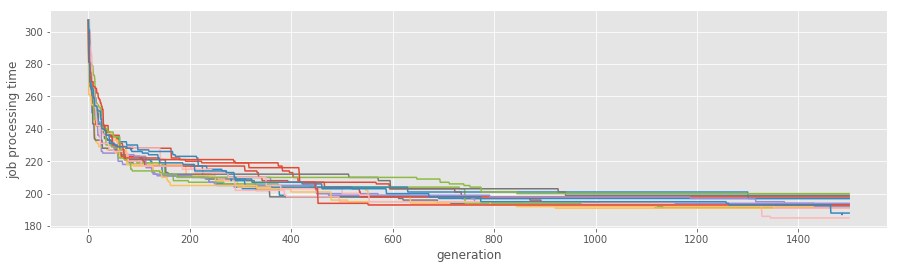

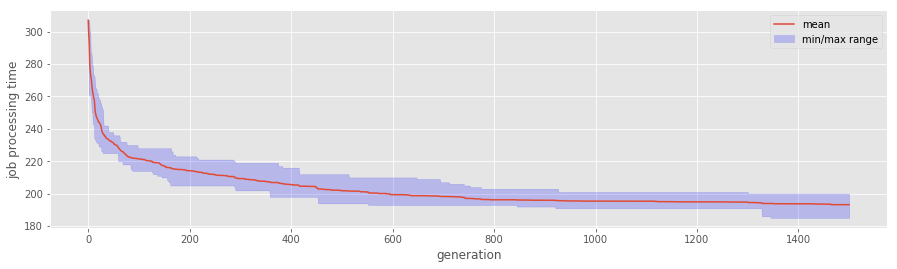

In [352]:
visualize(histories)

In [354]:
problem = IntegerProblem(50, [50]*3 + list(range(51, 100))*2)
selector = TournamentSelector(5)
# selector = RouletteSelector()
mutator = RandomGeneMutation(0.05, problem)
recombiner = IntegerSinglePointCrossover(0.6, problem)
# recombiner = IntegerUniformCrossover(0.6, problem)
replacer = DeleteAllReplacer()
# replacer = ElitesReplacer(50)

workers = 16
ga = GeneticAlgorithm(problem, 100, selector, mutator, recombiner, replacer, verbose=False)
histories_2 = [joblib.Parallel(n_jobs=workers)(
    joblib.delayed(ga.run)(1500) for _ in range(workers))]

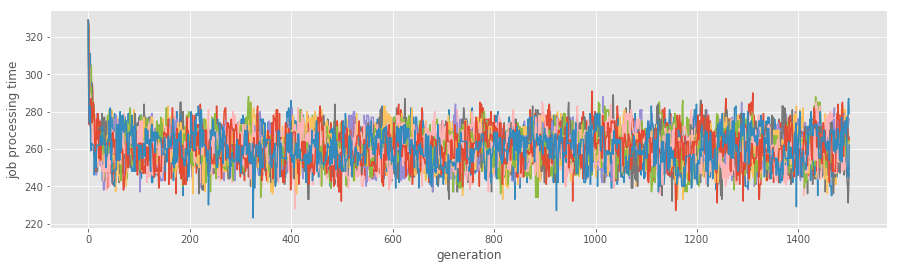

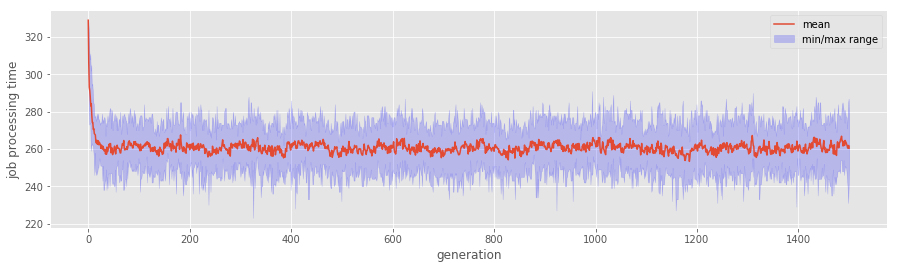

In [355]:
visualize(histories_2)

In [526]:
problem = IntegerProblem(50, [50]*3 + list(range(51, 100))*2)
selector = TournamentSelector(5)
# selector = RouletteSelector()
mutator = RandomGeneMutation(0.05, problem)
recombiner = IntegerSinglePointCrossover(0.6, problem)
# recombiner = IntegerUniformCrossover(0.6, problem)
replacer = ElitesReplacer(50)

workers = 16
ga = GeneticAlgorithm(problem, 100, selector, mutator, recombiner, replacer, verbose=False)
histories_3 = [joblib.Parallel(n_jobs=workers)(
    joblib.delayed(ga.run)(1500) for _ in range(workers))]

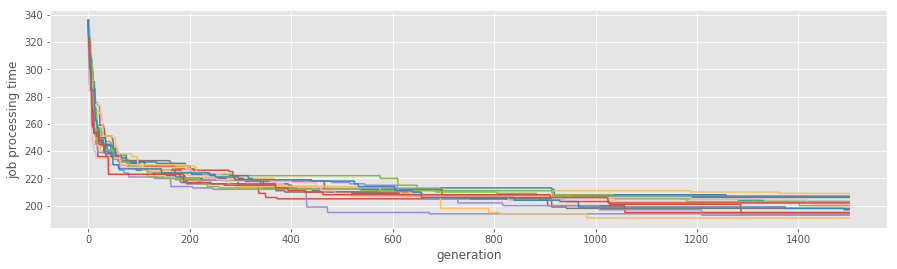

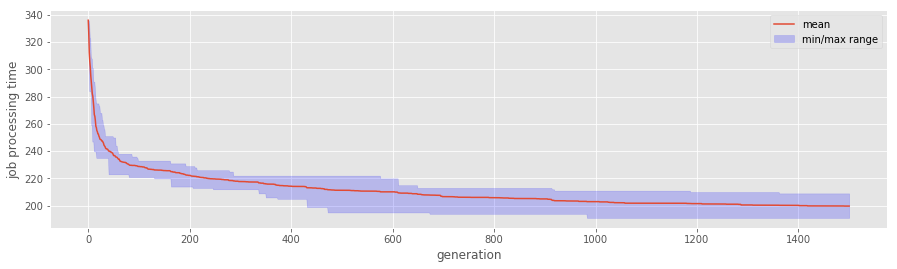

In [527]:
visualize(histories_3)

In [590]:
problem = IntegerProblem(50, [50]*3 + list(range(51, 100))*2)
selector = RankSelector()
mutator = RandomGeneMutation(0.05, problem)
recombiner = IntegerSinglePointCrossover(0.6, problem)
replacer = ElitesReplacer(5)

workers = 16
ga = GeneticAlgorithm(problem, 100, selector, mutator, recombiner, replacer, verbose=False)
histories_4 = [joblib.Parallel(n_jobs=workers)(
    joblib.delayed(ga.run)(1500) for _ in range(workers))]

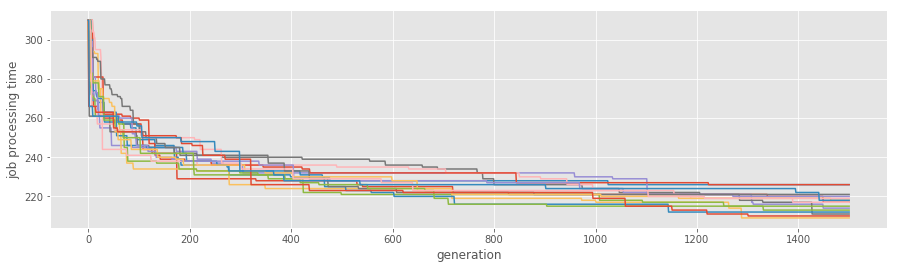

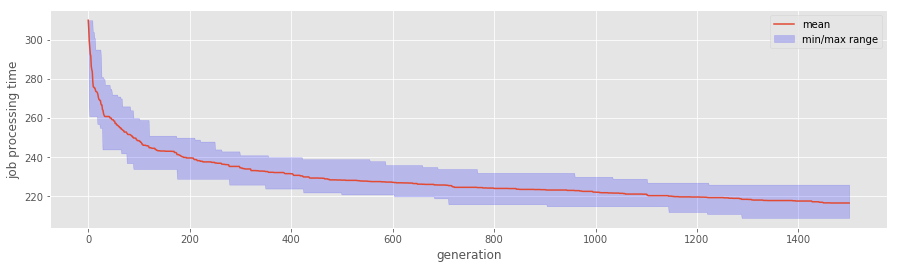

In [591]:
visualize(histories_4)

In [594]:
problem = IntegerProblem(50, [50]*3 + list(range(51, 100))*2)
selector = RouletteSelector()
mutator = RandomGeneMutation(0.05, problem)
recombiner = IntegerSinglePointCrossover(0.6, problem)
replacer = ElitesReplacer(5)

workers = 16
ga = GeneticAlgorithm(problem, 100, selector, mutator, recombiner, replacer, verbose=False)
histories_5 = [joblib.Parallel(n_jobs=workers)(
    joblib.delayed(ga.run)(1500) for _ in range(workers))]

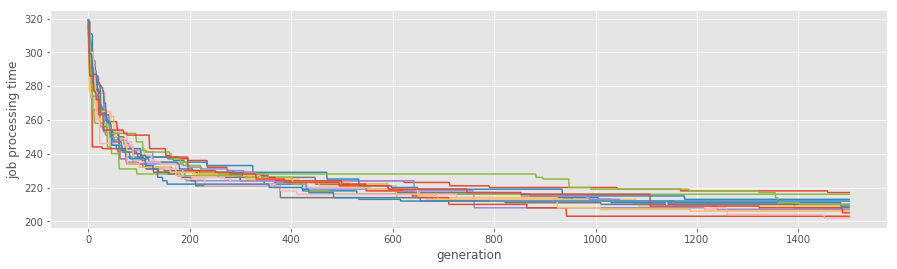

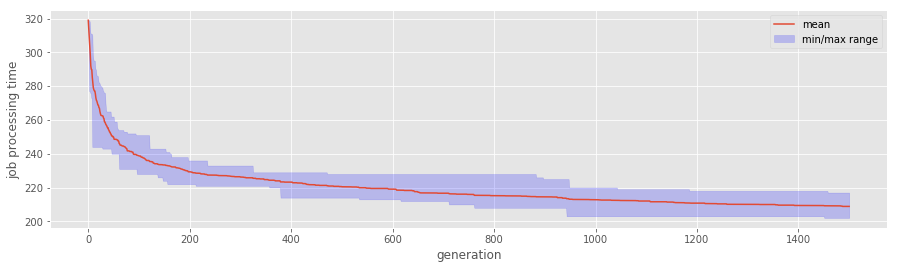

In [595]:
visualize(histories_5)

Experiments show that mutation and crossover operators are not very important for this particular problem, but selector and replacer are.

Best selector is `TournamentSelector`, and for replacer it is important to mix best parent and child individuals. For population size of 100 `ElitesSelector(50)`, which takes 50 best parents and 50 best children to the next generations works pretty well.

`DeleteAllSelector` lead to very stochastic performance, where optimal solution is often lost due to genetic operations.